## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import keras


In [2]:
from keras.regularizers import l1_l2

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, out_num=10, drop_ratio=0.2, l1_ratio=0.0, l2_ratio=0.0):
  """Code Here
  建立你的神經網路
  """
  neuron_num=[1024, 1024, 512, 512, 256, 256]
  input = keras.layers.Input(input_shape)
  x = keras.layers.BatchNormalization()(input)
  for i , num in enumerate(neuron_num):
    if i == 0:
      x = keras.layers.Dense(
          units=num,
          activation='relu',
          name=f'hidden_layer_{i+1}',
          kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
      x = keras.layers.Dropout(drop_ratio)(x)
    else:
      x = keras.layers.Dense(
          units=num,
          activation='relu',
          name=f'hidden_layer_{i+1}',
          kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
      x = keras.layers.Dropout(drop_ratio)(x)

  out = keras.layers.Dense(units=out_num, activation='softmax', name='output_layer')(x)
  model = keras.models.Model(inputs=input, outputs=out)

  return model

In [17]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512
Dropout_EXP = [0, 0.1]
l1_ratio=[0, 0.0005]
l2_ratio=[0, 0.0005]


In [18]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for n in l1_ratio:
  for m in l2_ratio:
    for j in Dropout_EXP:
      keras.backend.clear_session()
      print(f'EXP: [DR={j} L1={n} L2={m}]')
      model = build_mlp(
              x_train.shape[-1],
              drop_ratio=j,
              l1_ratio=n, 
              l2_ratio=m)
      optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
      model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
      
      model.summary()
      model.fit(
          x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle=True)
        
      train_loss = model.history.history["loss"]
      valid_loss = model.history.history["val_loss"]
      train_acc = model.history.history["accuracy"]
      valid_acc = model.history.history["val_accuracy"]

      name_tag = f'EXP: [DR={j} L1={n} L2={m}]'
      results[name_tag] = {
          'train_loss': train_loss,
          'valid_loss': valid_loss,
          'train_acc': train_acc,
          'valid_acc': valid_acc}

EXP: [DR=0 L1=0 L2=0]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1024)              3146752   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 512

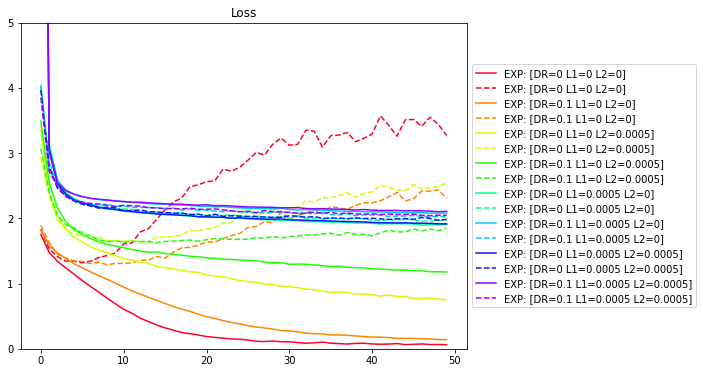

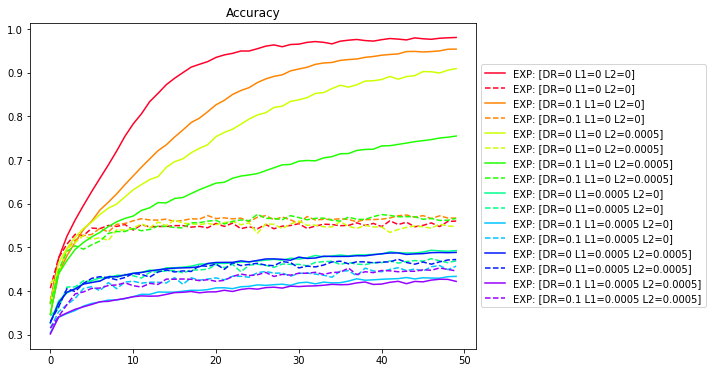

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]


plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,5])
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy")
plt.show()